### **Práctica 2 - Machine Learning III**

**Objetivo**: 
1. Analizar el conjunto de datos. 
2. Crear un sistema de recomendación de artistas para usuarios.
   
**Entregar**: Este cuaderno de jupyter con el trabajo hecho y comentado.

**Datos**: 

Los datos suministrados ya han sido procesados, limpiados y estructurados para simplificar su manejo y análisis. 

Para aquellos interesados en explorar y manipular el conjunto de datos original, así como entender la estructura, podéis descargarlo directamente aquí: 

https://grouplens.org/datasets/hetrec-2011/.

In [1]:
### ARCHIVOS DE DATOS DISPONIBLES: 
#1. artists.dat: info de los artistas que escuchan y etiquetan (tag) los users
#2. tags.dat: info de los tags que se pueden asignar a los artistas
#3. user_artists.dat: info de los artistas que escuchan los usuarios
#4. user_friends.dat: info de los amigos de los usuarios
#5. user_taggedartists.dat: tags que los usuarios asignan a los artistas
#6. user_taggedartists-timestamps.dat: igual que el anterior pero con timestamps

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [3]:
#Info artistas
artists.head()

,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531


In [4]:
#artistas escuchados por cada usuario. 
### Sobre weight: 
#listening count para cada [user,artist] pair.
#Me imagino que serán los minutos.
#Podemos utilizarlo como rating, más minutos, más le gusta.

users.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
#Tag que el usuario asigna a un artista, y en el momento en el que se lo asignó.
user_tag_artist.head()


,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [6]:
#POSIBLES TAGS QUE SE PUEDEN ASIGNAR:
print("\nInformación de etiquetas:")
print(tags.head())



Información de etiquetas:
   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


In [7]:
#Artistas con más listeners.
artists.sort_values(by='listeners', ascending=False).head(10)

,artistID,name,freq,listeners
12,65,Coldplay,369,5369132
11,154,Radiohead,393,4718748
38,220,Red Hot Chili Peppers,222,4608144
2,288,Rihanna,484,4542147
43,475,Eminem,204,4504111
16,229,The Killers,304,4416820
81,331,Kanye West,134,4375723
24,234,Nirvana,258,4257983
8,190,Muse,400,4080161
42,959,Queen,208,4002970


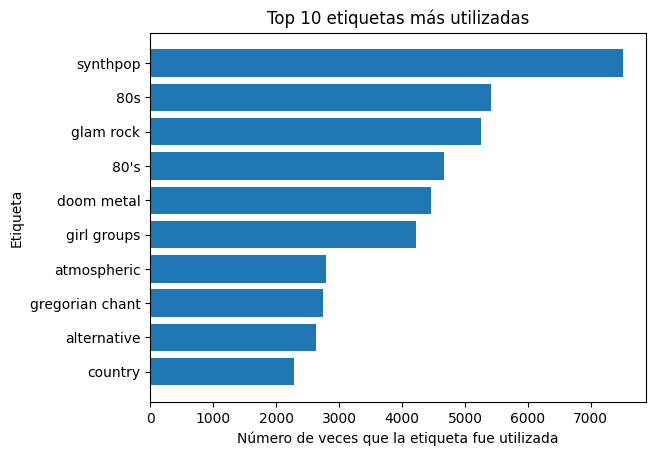

In [8]:
# Contar la frecuencia de aparición de las etiquetas
tag_counts = user_tag_artist['tagID'].value_counts().sort_values(ascending=False)[:10]
top_tags = tags.loc[tag_counts.index]['tagValue']

plt.barh(top_tags, tag_counts)
plt.xlabel('Número de veces que la etiqueta fue utilizada')
plt.ylabel('Etiqueta')
plt.title('Top 10 etiquetas más utilizadas')
plt.gca().invert_yaxis()
plt.show()


{'whiskers': [<matplotlib.lines.Line2D at 0x22c57b11720>,
 'caps': [<matplotlib.lines.Line2D at 0x22c57b11c60>,
 'boxes': [<matplotlib.lines.Line2D at 0x22c57b11480>],
 'medians': [<matplotlib.lines.Line2D at 0x22c57b121a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22c57b12440>],
 'means': []}

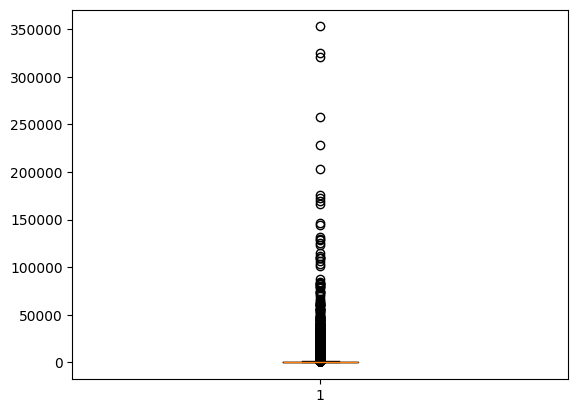

In [9]:
#Boxplot de la variable weight 
plt.boxplot(users['weight'])

In [12]:
len(users)

92834

In [13]:
#Outliers: consideramos outliers los puntos que estén 3 desviaciones estándar por encima de la media.
media = users['weight'].mean()
std = users['weight'].std()
outliers = users[users['weight'] > media + 3*std]

#Porcentaje de outliers respecto al total de datos
out_prop= len(outliers)/len(users)*100
print("Los outliers representan el", out_prop, "% de los datos")

Los outliers representan el 0.528901049184566 % de los datos


Comentario:Se decidió no eliminar los outliers ya que representaban un porcentaje muy pequeño del total

### PLANTEAMIENTO DEL PROBLEMA: 
- Problema: Lo que queremos es proporcionar recomendaciones de artistas nuevos a un usuario. 
- Es un problema implícito ya que no tenemos ratings/calificaciones explícitas como tal, si no que tenemos el número de minutos escuchados.

#### User-based collaborative filtering: 
- Solución: Buscar usuarios que sean similares al usuario target para poder hacer las recomendaciones. 

- Vamos a utilizar la matriz de usuarios-artistas (Sería la matriz de ratings): 
    - Dimensiones: (mxn), m usuarios, n artistas.
    - Cada fila de la matriz es un usuario y cada columna es un artista.
    - Cada celda es el número de veces/minutos que el usuario escuchó al artista (weight)

- Cómo calcular la similitud entre usuarios? 
    - Utilizando similitud del coseno 
    - Utilizando fórmula de Pearson

- Cuando tengamos los k usuarios más similares a nuestro usuario target u (Basado en similitud)
    - Para los artistas que u no ha escuchado crearemos un rating basado en lo que los k usuarios calificaron ponderado por su peso (similitud)
    - Ordenamos por rating descendente y hacemos top-n recomendaciones. 


In [15]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
# Merge users and artist datasets
df = pd.merge(users, artists, on='artistID', how='inner')

# Take a look at the data
df.head()

,userID,artistID,weight,name,freq,listeners
0,2,51,13883,Duran Duran,111,1588349
1,4,51,228,Duran Duran,111,1588349
2,27,51,85,Duran Duran,111,1588349
3,28,51,10,Duran Duran,111,1588349
4,62,51,528,Duran Duran,111,1588349


In [17]:
df['weight'].mean()

816.4413876218122

USO WEIGHT COMO EL RATING NO SE SI ESTA BIEN 

In [18]:
# Aggregate by artist
agg_ratings = df.groupby('name').agg(mean_rating = ('weight', 'mean'),
                                                number_of_ratings = ('weight', 'count')).reset_index()

In [19]:
# Artistas que han sido escuchados por más usuarios distintos. (Más ratings)
agg_ratings.sort_values(by='number_of_ratings', ascending=False).head(10)

,name,mean_rating,number_of_ratings
2231,Lady Gaga,2113.563011,611
645,Britney Spears,4584.559387,522
3205,Rihanna,1870.708678,484
3731,The Beatles,1379.408333,480
2123,Katy Perry,1125.887949,473
2421,Madonna,2147.314685,429
369,Avril Lavigne,1261.016787,417
833,Christina Aguilera,2600.503686,407
2691,Muse,1212.690000,400
2951,Paramore,2414.659148,399


In [20]:
# Keep the artist with over 100 ratings (100 Listeners)
# Tenemos 125 artistas.
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 20 to 4440
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               125 non-null    object 
 1   mean_rating        125 non-null    float64
 2   number_of_ratings  125 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 3.9+ KB


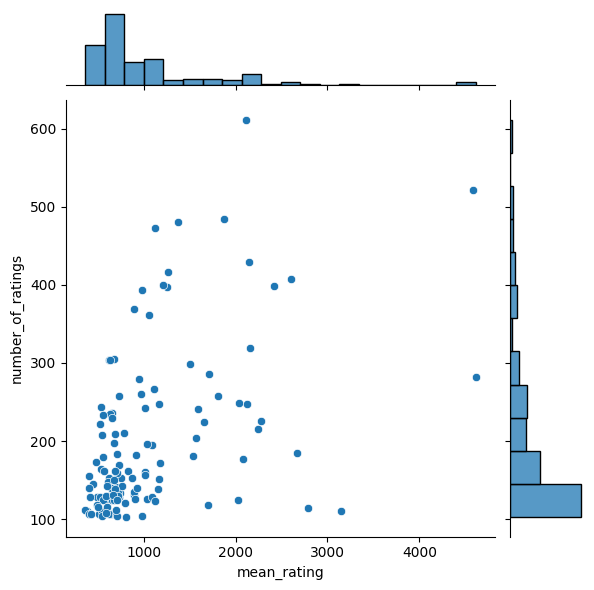

In [21]:
# Visualization
# Relación entre el rating medio y el número de ratings de cada artista.
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [22]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['name']], on='name', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24809 entries, 0 to 24808
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userID     24809 non-null  int64 
 1   artistID   24809 non-null  int64 
 2   weight     24809 non-null  int64 
 3   name       24809 non-null  object
 4   freq       24809 non-null  int64 
 5   listeners  24809 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.3+ MB


In [23]:
# Number of artists
print('The ratings dataset has', df_GT100['artistID'].nunique(), 'unique artists')

# Number of users
print('The ratings dataset has', df_GT100['userID'].nunique(), 'unique users')

# Average of weights
average_weight = df_GT100['weight'].mean()
print('The average weight is', average_weight)

# Median of weights
median_weight = df_GT100['weight'].median()
print('The median weight is', median_weight)

# Standard deviation of weights
std_weight = df_GT100['weight'].std()
print('The standard deviation of weights is', std_weight)


The ratings dataset has 125 unique artists
The ratings dataset has 1813 unique users
The average weight is 1239.1598613406425
The median weight is 341.0
The standard deviation of weights is 6322.424265102358


In [24]:
# Create user-item matrix 
# No hay user 1 o sea que está bien. 
matrix = df_GT100.pivot_table(index='userID', columns='name', values='weight')
matrix.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.0,259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,809.0,1553.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.904762,-6.095238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,-3179.666667,-2435.666667,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# User similarity matrix using Pearson correlation
user_similarity_pearson = matrix_norm.T.corr()
user_similarity_pearson.head()

userID,2,4,5,6,7,8,9,10,11,12,...,2086,2087,2088,2090,2091,2092,2093,2094,2096,2097
userID,,,,,,,,,,,,,,,,,,,,,
2,1.000000,-0.576091,NaN,NaN,-0.547734,NaN,NaN,NaN,-1.000000,NaN,...,NaN,-0.549090,-1.000000,NaN,-1.0,NaN,NaN,NaN,NaN,-0.421803
4,-0.576091,1.000000,0.544016,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.581765,0.999703
5,NaN,0.544016,1.000000,NaN,NaN,NaN,NaN,-0.456452,-1.000000,NaN,...,0.842446,NaN,0.675617,1.0,NaN,0.287328,NaN,NaN,0.260677,0.059629
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.547734,NaN,NaN,NaN,1.000000,-0.056068,NaN,NaN,0.165719,-0.452562,...,NaN,0.040023,0.631912,NaN,NaN,NaN,NaN,-0.868406,NaN,NaN


In [27]:
# User similarity matrix using cosine similarity.
# Rellenamos con 0s los Nans porque coseno no deja. 
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

array([[ 1.        , -0.27311313,  0.        , ...,  0.051086  ,
         0.04379327, -0.15481241],
       [-0.27311313,  1.        , -0.08726293, ...,  0.        ,
        -0.02760951,  0.85320862],
       [ 0.        , -0.08726293,  1.        , ...,  0.        ,
         0.02241791,  0.01037731],
       ...,
       [ 0.051086  ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.04379327, -0.02760951,  0.02241791, ...,  0.        ,
         1.        ,  0.03833763],
       [-0.15481241,  0.85320862,  0.01037731, ...,  0.        ,
         0.03833763,  1.        ]])

In [29]:
# Pick a user ID
picked_userid = 2

# Remove picked user ID from the candidate list
user_similarity_pearson.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity_pearson.head()

userID,2,4,5,6,7,8,9,10,11,12,...,2086,2087,2088,2090,2091,2092,2093,2094,2096,2097
userID,,,,,,,,,,,,,,,,,,,,,
4,-0.576091,1.000000,0.544016,NaN,NaN,NaN,NaN,-1.000000,NaN,NaN,...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.581765,0.999703
5,NaN,0.544016,1.000000,NaN,NaN,NaN,NaN,-0.456452,-1.000000,NaN,...,0.842446,NaN,0.675617,1.0,NaN,0.287328,NaN,NaN,0.260677,0.059629
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-0.547734,NaN,NaN,NaN,1.000000,-0.056068,NaN,NaN,0.165719,-0.452562,...,NaN,0.040023,0.631912,NaN,NaN,NaN,NaN,-0.868406,NaN,NaN
8,NaN,NaN,NaN,NaN,-0.056068,1.000000,NaN,NaN,0.705680,0.997594,...,NaN,0.537092,-0.447645,NaN,NaN,NaN,NaN,-0.375799,NaN,NaN


In [31]:
# most similar users 
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity_pearson[user_similarity_pearson[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 2 are userID
1102    1.0
643     1.0
1339    1.0
1474    1.0
1471    1.0
1458    1.0
1419    1.0
1411    1.0
1383    1.0
1134    1.0
Name: 2, dtype: float64


we will narrow down the item pool by doing the following:
1. Remove the artists that have been listened by the target user (user ID 1 in this example).
2. Keep only the artists that similar users have listened.

To remove the artists listened by the target user, we keep only the row for `userId=2` in the user-item matrix and remove the items with missing values.

In [32]:
# artists that the target user has listened to
picked_userid_listened = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_listened

name,Coldplay,Daft Punk,Depeche Mode,Duran Duran,Gorillaz,Kylie Minogue,Lady Gaga,Madonna,New Order,Portishead
userID,,,,,,,,,,
2,-1208.4,1364.6,-2168.4,9095.6,-3234.4,4195.6,-3268.4,-1486.4,-450.4,-2839.4


To keep only the similar users' movies, we keep the user IDs in the top 10 similar user lists and remove the film with all missing values. All missing value for a movie means that none of the similar users have watched the movie.


In [33]:
# Artists that similar users listened. Remove artists that none of the similar users have watched
similar_user_artists = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_artists

name,30 Seconds to Mars,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,Ashlee Simpson,Avril Lavigne,Beyoncé,Björk,...,Snow Patrol,System of a Down,The Beatles,The Doors,The Killers,The Kooks,The Pussycat Dolls,The Smashing Pumpkins,The Smiths,The Strokes
userID,,,,,,,,,,,,,,,,,,,,,
643,NaN,NaN,NaN,NaN,-50.818182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.818182,-205.818182,NaN
1102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-454.583333,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1339,NaN,NaN,NaN,NaN,NaN,-4183.96,NaN,-6656.960000,NaN,NaN,...,-8008.96,NaN,-5177.96,NaN,-5367.960000,-7909.96,NaN,NaN,NaN,-4293.96
1383,NaN,NaN,NaN,NaN,NaN,-824.50,NaN,NaN,NaN,1924.5,...,NaN,NaN,1262.50,-787.500000,NaN,NaN,NaN,NaN,NaN,NaN
1411,NaN,-339.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-355.307692,NaN,NaN,NaN,NaN,NaN,NaN
1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-205.00,-183.0,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN
1458,13.714286,10.714286,-21.285714,19.714286,NaN,NaN,-0.285714,10.714286,19.714286,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,NaN,-1844.275862,NaN,NaN,NaN,NaN,NaN,NaN,-1691.275862,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1852.275862,NaN,NaN,NaN


In [34]:
# Remove the already listened artists from the movie list
similar_user_artists.drop(picked_userid_listened.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_artists

name,30 Seconds to Mars,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,Ashlee Simpson,Avril Lavigne,Beyoncé,Björk,...,Snow Patrol,System of a Down,The Beatles,The Doors,The Killers,The Kooks,The Pussycat Dolls,The Smashing Pumpkins,The Smiths,The Strokes
userID,,,,,,,,,,,,,,,,,,,,,
643,NaN,NaN,NaN,NaN,-50.818182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-25.818182,-205.818182,NaN
1102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-454.583333,NaN,NaN,NaN,NaN,NaN
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.090909,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1339,NaN,NaN,NaN,NaN,NaN,-4183.96,NaN,-6656.960000,NaN,NaN,...,-8008.96,NaN,-5177.96,NaN,-5367.960000,-7909.96,NaN,NaN,NaN,-4293.96
1383,NaN,NaN,NaN,NaN,NaN,-824.50,NaN,NaN,NaN,1924.5,...,NaN,NaN,1262.50,-787.500000,NaN,NaN,NaN,NaN,NaN,NaN
1411,NaN,-339.307692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-355.307692,NaN,NaN,NaN,NaN,NaN,NaN
1419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-205.00,-183.0,NaN,NaN,54.000000,NaN,NaN,NaN,NaN,NaN
1458,13.714286,10.714286,-21.285714,19.714286,NaN,NaN,-0.285714,10.714286,19.714286,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1471,NaN,-1844.275862,NaN,NaN,NaN,NaN,NaN,NaN,-1691.275862,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1852.275862,NaN,NaN,NaN


In [35]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_artists.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_artists[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['artist', 'artist_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='artist_score', ascending=False)

# Select top m artists
m = 10
ranked_item_score.head(m)

,artist,artist_score
55,Paramore,18150.642333
14,Britney Spears,13766.285030
36,Kings of Leon,5979.770000
9,Björk,1924.500000
19,Eminem,266.000000
23,Florence + the Machine,209.181818
3,Amy Winehouse,19.714286
0,30 Seconds to Mars,13.714286
6,Ashlee Simpson,-0.285714
50,Nickelback,-2.909091


predict score 

In [36]:
# Average rating for the picked user
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Print the average movie rating for user 1
print(f'The average movie rating for user {picked_userid} is {avg_rating:.2f}')

The average movie rating for user 2 is 4787.40


In [37]:
# Calcuate the predicted rating: 
ranked_item_score['predicted_rating'] = ranked_item_score['artist_score'] + avg_rating

# Take a look at the data
ranked_item_score.head(m)

,artist,artist_score,predicted_rating
55,Paramore,18150.642333,22938.042333
14,Britney Spears,13766.285030,18553.685030
36,Kings of Leon,5979.770000,10767.170000
9,Björk,1924.500000,6711.900000
19,Eminem,266.000000,5053.400000
23,Florence + the Machine,209.181818,4996.581818
3,Amy Winehouse,19.714286,4807.114286
0,30 Seconds to Mars,13.714286,4801.114286
6,Ashlee Simpson,-0.285714,4787.114286
50,Nickelback,-2.909091,4784.490909


### 2. ITEM BASED 

In [38]:
df_GT100

,userID,artistID,weight,name,freq,listeners
0,2,51,13883,Duran Duran,111,1588349
1,4,51,228,Duran Duran,111,1588349
2,27,51,85,Duran Duran,111,1588349
3,28,51,10,Duran Duran,111,1588349
4,62,51,528,Duran Duran,111,1588349
...,...,...,...,...,...,...
24804,2018,1934,95,Adele,126,2845761
24805,2033,1934,1234,Adele,126,2845761
24806,2037,1934,1457,Adele,126,2845761
24807,2038,1934,125,Adele,126,2845761


In [41]:
import tqdm as notebook_tqdm
import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

In [51]:
df_cornac = df_GT100[['userID', 'artistID', 'weight']]

In [52]:
type(df_cornac)

pandas.core.frame.DataFrame

In [53]:
#put data_cornac into cornac format
data_cornac = df_cornac.astype({'userID': 'int', 'artistID': 'int'}).to_records(index=False)
data_cornac = list(data_cornac)

In [56]:
data_cornac

[(2, 51, 13883),
 (4, 51, 228),
 (27, 51, 85),
 (28, 51, 10),
 (62, 51, 528),
 (63, 51, 563),
 (66, 51, 910),
 (73, 51, 1962),
 (96, 51, 63),
 (117, 51, 1244),
 (128, 51, 5254),
 (141, 51, 548),
 (142, 51, 221),
 (176, 51, 4266),
 (185, 51, 49),
 (187, 51, 295),
 (191, 51, 23),
 (196, 51, 6015),
 (211, 51, 128),
 (224, 51, 303),
 (263, 51, 386),
 (264, 51, 524),
 (266, 51, 55),
 (269, 51, 26),
 (275, 51, 77),
 (290, 51, 23),
 (306, 51, 76),
 (338, 51, 2002),
 (359, 51, 1317),
 (374, 51, 71),
 (397, 51, 60),
 (423, 51, 732),
 (428, 51, 61012),
 (430, 51, 7488),
 (436, 51, 2178),
 (446, 51, 3669),
 (452, 51, 172),
 (453, 51, 235),
 (480, 51, 330),
 (488, 51, 165),
 (499, 51, 7),
 (515, 51, 274),
 (539, 51, 42),
 (540, 51, 4753),
 (568, 51, 450),
 (576, 51, 398),
 (577, 51, 71),
 (592, 51, 16725),
 (596, 51, 536),
 (643, 51, 940),
 (656, 51, 263),
 (658, 51, 220),
 (683, 51, 3127),
 (686, 51, 719),
 (694, 51, 332),
 (699, 51, 1010),
 (714, 51, 439),
 (761, 51, 3500),
 (769, 51, 238),
 (78

In [58]:
# ItemKNN methods
K = 50  # number of nearest neighbors
SEED = 29 
VERBOSE =  False  
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

ratio_split = RatioSplit(data_cornac, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                       |      RMSE | Train (s) | Test (s)
---------------------- + --------- + --------- + --------
ItemKNN-Cosine         | 1736.6886 |    0.0709 |   0.6284
ItemKNN-Pearson        | 1687.5728 |    0.0712 |   1.0789
ItemKNN-Pearson-MC     | 1685.8195 |    0.0506 |   0.9659
ItemKNN-AdjustedCosine | 1700.3264 |    0.1555 |   0.7629



Vemos que el que menor RMSE tiene es el coseno ajustado.

In [69]:
def itemRecomendations(itemId):
    name = df_GT100[df_GT100['artistID'] == itemId]['name'].values[0]
    print(f"Top 5 usuarios a los que recomendarles el artista {name}:")
    results = []
    users = list(iknn_adjusted.uid_map.keys())
    ids = list(iknn_adjusted.uid_map.values())
    for i in range(len(iknn_adjusted.uid_map)-1):
        results.append((users[i], iknn_adjusted.score(ids[i], iknn_adjusted.iid_map[itemId])))
    # return the top 5 recommendations
    results = sorted(results, key=lambda x: x[1], reverse=True)
    return results[:5]

In [70]:
#Le introducimos un id de artista y obtenemos usuarios a los que les gustaría ese artista.
itemRecomendations(51)

Top 5 usuarios a los que recomendarles el artista Duran Duran:


[(542, 99553.8980919152),
 (1642, 79394.5042136852),
 (1664, 66664.94293415284),
 (1094, 50286.15172883774),
 (459, 36560.487020914516)]

### 3. MODEL BASED: 

Para nuestro enfoque basado en modelos, utilizaremos la Descomposición en Valores Singulares (Singular Value Decomposition, SVD), que es una técnica de factorización de matrices.

SVD se utiliza para descomponer una matriz en otras tres matrices: M = U*sigma*Vt.

Se emplea para reducir el número de características de un conjunto de datos al disminuir la dimensión de la matriz.

In [71]:
#Partiremos del conjunto creado antes df_GT100
df_GT100.head()

,userID,artistID,weight,name,freq,listeners
0,2,51,13883,Duran Duran,111,1588349
1,4,51,228,Duran Duran,111,1588349
2,27,51,85,Duran Duran,111,1588349
3,28,51,10,Duran Duran,111,1588349
4,62,51,528,Duran Duran,111,1588349


In [73]:
#A partir de este, creamos la matriz de ratings R_df. Tendrá NaNs en los artistas que no han sido escuchados por un usuario
#Habrá muchos NaNs ya que en sistemas de recomendación tratamos con matrices muy dispersas.
R_df = df_GT100.pivot(index = 'userID', columns ='name', values = 'weight')
R_df.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,374.0,259.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,809.0,1553.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
#Los NaNs los rellenamos con 0s
R_df = R_df.fillna(0)
R_df.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
userID,,,,,,,,,,,,,,,,,,,,,
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,374.0,259.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,809.0,1553.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
#Centraremos la matriz de ratings utilizando la media de cada usuario. 
R = R_df.to_numpy()

user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

print(R.shape)
print(np.count_nonzero(R))

(1813, 125)
24809


In [81]:
from scipy.sparse.linalg import svds
import math
from numpy.linalg import matrix_rank


In [82]:
#Como tenemos 124 columnas, vamos a iterar para distintos valores de k y ver cómo se comporta el error.
latents = [3, 10, 20, 30, 40, 50, 100, 120, 124]
rmse_errors = [] 
for latent_dim in latents:
    U, sigma, Vt = svds(R_demeaned, k=latent_dim)
    #Matriz sigma: es una matriz diagonal de valores singulares
    sigma = np.diag(sigma)
    Rpred = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    Rpred[Rpred < 0] = 0
    Rpred[Rpred > 5] = 5
    MSE = np.square(np.subtract(R, Rpred)).mean() 
    RMSE = math.sqrt(MSE)
    rmse_errors.append(RMSE)

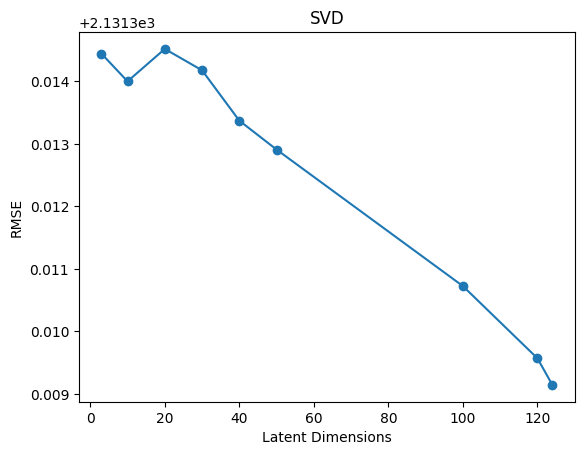

In [83]:
import seaborn as sns
plt.xlabel('Latent Dimensions')
plt.ylabel('RMSE')
plt.title('SVD')
plt.plot(latents, rmse_errors, 'o-')
plt.show()

Comentario: podemos ver que el error RMSE disminuye a medida que nos vamos acercando a L=rank_matriz 

In [84]:
#En este caso escogemos 100 dimensiones latentes. 
latent_dim = 100

U, sigma, Vt = svds(R_demeaned, k=latent_dim)

sigma = np.diag(sigma)

#Predicciones: le sumamos la media del usuario. 
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

#Creamos un dataframe con las predicciones
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = R_df.columns)
preds_df.head()

name,30 Seconds to Mars,3OH!3,AC/DC,Adam Lambert,Adele,Alanis Morissette,Alicia Keys,Amy Winehouse,Arcade Fire,Arctic Monkeys,...,The Smashing Pumpkins,The Smiths,The Strokes,The Veronicas,The White Stripes,Timbaland,U2,Yeah Yeah Yeahs,blink-182,t.A.T.u.
0,-1.172028,-7.260095,-123.302023,-130.428505,141.435988,35.088387,-216.094750,1.974383,300.614759,31.731354,...,-7.129002,-152.049251,-745.458910,29.432733,282.125099,58.891970,-8.079477,336.095461,6.846882,269.574619
1,-0.049188,8.674335,27.134660,0.455782,14.603163,-1.575489,1.920866,0.815465,4.121682,0.304266,...,-1.258038,64.673318,11.304421,-6.575860,-4.769321,12.031895,1.598105,11.801697,-2.104865,-7.031718
2,-0.219115,5.813422,33.708187,-4.951822,4.956415,-1.111675,4.705915,-0.130534,117.036386,258.579158,...,-1.271237,18.778805,14.577389,1.771222,66.477631,-0.561350,0.702033,53.562667,-7.833399,15.965998
3,-0.000153,-0.041577,-0.003221,-0.005423,-0.161405,0.032567,0.072858,0.001104,-0.014124,-0.004744,...,0.001145,0.006881,-0.009005,-0.002304,-0.003252,-0.159255,-0.000149,-0.011945,0.004249,-0.104952
4,-0.115496,71.783404,-245.393325,-7.905836,122.731154,878.272550,1476.882180,3.162261,-72.652867,0.125322,...,7.103640,-64.235045,-1.000967,1.861882,-57.648666,-47.605959,-0.763524,-49.528046,10.705291,-16.068788


In [85]:
#Función para recomendar artistas a un usuario

def recommend_artist(predictions_df, userID, artists_df, original_ratings_df, num_recommendations=5):
        
        # Get and sort the user's predictions
        user_row_number = userID - 1 # UserID starts at 1, not 0
        sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
        
        # Get the user's data and merge in the artist information.
        user_data = original_ratings_df[original_ratings_df.userID == (userID)]
        user_full = (user_data.merge(artists_df, how = 'left', left_on = 'artistID', right_on = 'artistID').
                        sort_values(['weight'], ascending=False)
                    )
    
        print('User {0} has already listened to {1} artists.'.format(userID, user_full.shape[0]))
        print('Recommending the highest {0} predicted ratings artists not already listened to.'.format(num_recommendations))
        
        # Recommend the highest predicted rating artists that the user hasn't listened to yet.
        recommendations = (artists_df[~artists_df['artistID'].isin(user_full['artistID'])].
            merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
                left_on = 'name',
                right_on = 'name').
            rename(columns = {user_row_number: 'Predictions'}).
            sort_values('Predictions', ascending = False).
                        iloc[:num_recommendations, :-1]
                        )
    
        return user_full, recommendations

In [88]:
#Ejemplo de recomendación para el usuario 2
already_listened, predictions = recommend_artist(preds_df, 2, artists, users, 5)
df = already_listened[["artistID"]].copy()
#df.head(5)
predictions.head(5)

User 2 has already listened to 50 artists.
Recommending the highest 5 predicted ratings artists not already listened to.


,artistID,name,freq,listeners
9,154,Radiohead,393,4718748
17,157,Michael Jackson,266,3533610
30,159,The Cure,229,2921091
95,161,Enrique Iglesias,121,1544997
20,163,Pink Floyd,258,3068781


In [90]:
#Evaluar el modelo
from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(prediction, ground_truth):
    #Lo que hacemos es comparar los nonzero items, que son los que tienen "rating" proporcionado por el usuario. 
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

#Calculamos el error RMSE
rmse_val = rmse(all_user_predicted_ratings, R)
print("rmse", rmse_val)

#Calculamos el MAPE 
def mape(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.mean(np.abs((ground_truth - prediction) / ground_truth)) * 100

mape_val = mape(all_user_predicted_ratings, R)
print("mape", mape_val)

rmse 185.23400750955332
mape 15.24848732558522


In [91]:
df_GT100["weight"].describe()

count     24809.000000
mean       1239.159861
std        6322.424265
min           1.000000
25%         139.000000
50%         341.000000
75%         852.000000
max      352698.000000
Name: weight, dtype: float64

Comentario: Obtuvimos un RMSE de 185.23 y un MAPE del 15.28%, lo que significa que nuestas predicciones distan en esa medida de los valores reales. 